# ColabPreprocess  --START
置換<br>

/kaggle/input/  <br>
/content/

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
! echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
! apt update
! apt install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current

                                 Dload  Upload   Total   Spent    Left  Speed

100  2659  100  2659    0     0  73861      0 --:--:-- --:--:-- --:--:-- 73861

OK

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease

Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease

Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]

Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]

Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]

Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]

Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]

Get:8 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5,004 B]

Get:9 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,070 kB]

Get:10 http://security.ubuntu.com/ubuntu f

#kaggle get_gcspath
from kaggle_datasets import KaggleDatasets
print(KaggleDatasets().get_gcs_path())

In [3]:
!pip install kaggle

In [4]:
! mkdir -p asl-fingerspelling
! gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 kds-7a1de6f6fb09cdad50ebab8364ce5c9e2937606d5437de561aab1448 asl-fingerspelling

I0712 02:13:18.466226 2023/07/12 02:13:18.466162 Start gcsfuse/1.0.0 (Go version go1.20.4) for app "" using mount point: /content/asl-fingerspelling


In [5]:
! mkdir -p aslfr-parquets-to-tfrecords-cleaned
! gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 kds-6720764106d040caa24754175e3c58fcbf8d829fba1b2c2d59149b30 aslfr-parquets-to-tfrecords-cleaned

I0712 02:13:21.136178 2023/07/12 02:13:21.136134 Start gcsfuse/1.0.0 (Go version go1.20.4) for app "" using mount point: /content/aslfr-parquets-to-tfrecords-cleaned


In [6]:
pip install Levenshtein



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.7 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:00




# --END  ColabPreprocess



1. I used two transformer layer in the encoder instead of four.
2. I used four attention heads instead of two.
3. I used new tokens for SOS, EOS, and padding (very minor since Rohith used rare tokens for these purposes, but still- more 'correct').
2. I fixed a bug (probably?) in the decoder's dropout layers, which did not have the training flag, resulting in dropout during inference. This change gave a nice bump in the score.
3. I made the passing of the training flag explicit. I know it can be implicit since it is a kwarg, but explicit passing makes the whole thing more straightforward and maybe fix another one or two training-flag-related bugs along the way.
4. I changed the positional encoding in the decoder from tf.keras.layers.Embedding to proper positional embeddings (i.e., the usual sines and cosines usually used for this purpose). This had a significant impact.
5. I added positional embedding to the encoder. This, too, had a significant impact.


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import Levenshtein as lev
import os
import gc

# EDA

inpdir = "/kaggle/input/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')
df["phrase_bytes"] = df["phrase"].map(lambda x: x.encode("utf-8"))
display(df.head())

train_landmarks = pd.read_parquet('/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet')
keys = train_landmarks.keys()[1:]
train_landmarks.head()

# TFRecord

LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]
POSE_LBLS = [f'x_pose_{i}' for i in POSE] + [f'y_pose_{i}' for i in POSE] + [f'z_pose_{i}' for i in POSE]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

SEL_COLS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(SEL_COLS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(SEL_COLS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(SEL_COLS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE]

print('SEL_COLS size:' + str(len(SEL_COLS)))

def load_relevant_data_subset(pq_path):
    return pd.read_parquet(pq_path, columns=SEL_COLS)

counter = 0
for file_id in tqdm(df.file_id.unique()):
    
    print(counter)
    counter+=1
    
    pqfile = f"{inpdir}/train_landmarks/{file_id}.parquet"
    if not os.path.isdir("tfds"): os.mkdir("tfds")
    tffile = f"tfds/{file_id}.tfrecord"
    seq_refs = df.loc[df.file_id == file_id]
    seqs = load_relevant_data_subset(pqfile)
    seqs_numpy = seqs.to_numpy()
    with tf.io.TFRecordWriter(tffile) as file_writer:
        for seq_id, phrase in zip(seq_refs.sequence_id, seq_refs.phrase_bytes):
            frames = seqs_numpy[seqs.index == seq_id]
            
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {SEL_COLS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(SEL_COLS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[phrase]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

# Data loading

#### Here I use new tokens for padding, start and end of sentences. (Capitals are good since the original phrases have only lower case letters, besides numbers and various signs).

In [7]:
pad_token = 'P'
start_token = 'S'
end_token = 'E'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

In [8]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)


char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx

num_to_char = {j:i for i,j in char_to_num.items()}


inpdir = "/kaggle/input/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')

LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]
POSE_LBLS = [f'x_pose_{i}' for i in POSE] + [f'y_pose_{i}' for i in POSE] + [f'z_pose_{i}' for i in POSE]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

SEL_COLS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(SEL_COLS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(SEL_COLS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(SEL_COLS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE]

print(RPOSE_IDX)

[47, 48, 49, 50, 51, 99, 100, 101, 102, 103, 151, 152, 153, 154, 155]


In [9]:
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
        print(x)
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

def translate_landmarks(landmarks, max_translation):
    translation = tf.random.uniform(shape=(1,), minval=-max_translation, maxval=max_translation)
    translated_landmarks = landmarks + translation
    return translated_landmarks

def scale_landmarks(landmarks, min_scale, max_scale):
    scale_factor = tf.random.uniform(shape=(1,), minval=min_scale, maxval=max_scale)
    scaled_landmarks = landmarks * scale_factor
    return scaled_landmarks

def pre_process(x):

    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)

    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)

    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)

    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose

        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)

        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose

    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)

    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)

    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)

    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

In [10]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def preprocess_fn(landmarks, phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)

    # landmarksを前処理する
    if tf.random.uniform(()) < 0.5:  # Random chance to perform translation
        landmarks = translate_landmarks(landmarks, max_translation=10)
    if tf.random.uniform(()) < 0.5:  # Random chance to perform scaling
        landmarks = scale_landmarks(landmarks, min_scale=0.8, max_scale=1.2)

    return pre_process(landmarks), phrase


def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in SEL_COLS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in SEL_COLS])
    landmarks = tf.transpose(landmarks)

    return landmarks, phrase


In [11]:
inpdir = "/kaggle/input/aslfr-parquets-to-tfrecords-cleaned"
tffiles = df.file_id.map(lambda x: f'{inpdir}/tfds/{x}.tfrecord').unique()

batch_size = 32
val_len = int(0.05 * len(tffiles))

train_dataset = tf.data.TFRecordDataset(tffiles[val_len:]).map(decode_fn).map(preprocess_fn).shuffle(30000, reshuffle_each_iteration=True).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.TFRecordDataset(tffiles[:val_len]).map(decode_fn).map(preprocess_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


Tensor("cond_3/Pad:0", shape=(None, 26, 3), dtype=float32)
Tensor("cond_3/Pad:0", shape=(None, 26, 3), dtype=float32)


# The model

In [12]:
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]

POSE = LPOSE + RPOSE

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]
POSE_LBLS = [f'x_pose_{i}' for i in POSE] + [f'y_pose_{i}' for i in POSE] + [f'z_pose_{i}' for i in POSE]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

SEL_COLS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(SEL_COLS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(SEL_COLS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(SEL_COLS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE]

print('SEL_COLS size:' + str(len(SEL_COLS)))

SEL_COLS size:156


#### Here I implemented proper positional embeddings for both the encoder and the decoder.

In [13]:
class MLPBlock(tf.keras.layers.Layer):
    def __init__(self, num_hid=64, num_layers=5):
        super().__init__()
        self.mlp = tf.keras.Sequential()
        for _ in range(num_layers):
            self.mlp.add(tf.keras.layers.Dense(num_hid, activation=tf.nn.gelu))
        self.mlp.add(tf.keras.layers.Dense(num_hid))

    def call(self, inputs):
        return self.mlp(inputs)


class TokenEmbedding(keras.layers.Layer):
    def __init__(self, num_vocab=61, maxlen=50, num_hid=256, mlp_num_layers=5):
        super().__init__()
        self.num_hid = num_hid
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = self.positional_encoding(maxlen - 1, num_hid)
        self.mlp_block = MLPBlock(num_hid, num_layers=mlp_num_layers)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x) * tf.math.sqrt(tf.cast(self.num_hid, tf.float32))
        x = x + self.pos_emb[:maxlen, :]
        x = self.mlp_block(x)
        return x

    def positional_encoding(self, maxlen, num_hid):
        positions = tf.range(maxlen, dtype=tf.float32)[..., tf.newaxis]
        depth = num_hid // 2
        angles = positions / tf.pow(10000, tf.range(0, depth, 1, dtype=tf.float32) / num_hid)  # depthのインクリメントを修正
        pos_encoding = tf.concat([tf.sin(angles), tf.cos(angles)], axis=-1)
        return pos_encoding



class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.num_hid = num_hid
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        #self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)
        '''
        self.pos_emb = tf.math.divide(
            self.positional_encoding(maxlen-1, num_hid),
            tf.math.sqrt(tf.cast(num_hid, tf.float32)))
        '''
        self.pos_emb = self.positional_encoding(maxlen-1, num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        '''
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions
        '''
        return x + self.pos_emb[:maxlen, :]
    
    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding




In [14]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, num_hid=256, maxlen=100):
        super(LandmarkEmbedding, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(num_hid, 11, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()

        self.conv2 = tf.keras.layers.Conv1D(num_hid, 11, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.2)

        self.conv3 = tf.keras.layers.Conv1D(num_hid, 11, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.leaky_relu3 = tf.keras.layers.LeakyReLU()
        self.dropout3 = tf.keras.layers.Dropout(0.2)

        self.conv4 = tf.keras.layers.Conv1D(num_hid, 11, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.leaky_relu4 = tf.keras.layers.LeakyReLU()
        self.dropout4 = tf.keras.layers.Dropout(0.2)

        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        self.pos_emb = self.positional_encoding(maxlen, num_hid)
        self.maxlen = maxlen
        self.num_hid = num_hid

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu3(x)
        x = self.dropout3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky_relu4(x)
        x = self.dropout4(x)
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        x = x + self.pos_emb

        return self.sigmoid(x)

    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype=tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype=tf.float32)[tf.newaxis, :] / depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)
        return pos_encoding


In [15]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#### Here I added the training flag to the TransformerDecoder's Dropout layers.

In [16]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

#### Here I made the passing of the training flag explicit.

In [17]:
class Transformer(tf.keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [18]:
# 正解率を計算するためのメトリクスを作成
train_accuracy = tf.keras.metrics.CategoricalAccuracy()
val_accuracy = tf.keras.metrics.CategoricalAccuracy()

# 学習ループ内で正解率を更新するコールバックを定義
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = train_accuracy.result()
        val_acc = val_accuracy.result()
        print(f"Epoch {epoch+1}: Train Accuracy = {train_acc}, Validation Accuracy = {val_acc}")
        # 正解率をリセット
        train_accuracy.reset_states()
        val_accuracy.reset_states()
# val_lossが3回マイナスになった場合に学習を停止するコールバック
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=7):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.min_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print("Training stopped due to early stopping.")

batch = next(iter(val_dataset))
idx_to_char = list(char_to_num.keys())

model = Transformer(
    num_hid=256,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=3,
    num_layers_dec=1,
    num_classes=62,
)



loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
accuracy_callback = AccuracyCallback()
optimizer = keras.optimizers.Adam(0.0001)


# モデルのコンパイル
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[train_accuracy])

In [19]:
#modelアーキテクト
#tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)


In [20]:
# ##Optuna
# pip install optuna

In [21]:
%%time
# EarlyStoppingCallbackをコールバックリストに追加して学習を行う
history = model.fit(train_dataset, verbose=2, validation_data=val_dataset, epochs=100,
                    callbacks=[AccuracyCallback(), EarlyStoppingCallback()])


Epoch 1/100
Epoch 1: Train Accuracy = 0.0, Validation Accuracy = 0.0
1520/1520 - 220s - loss: 0.8408 - val_loss: 0.7767 - 220s/epoch - 145ms/step
Epoch 2/100
Epoch 2: Train Accuracy = 0.0, Validation Accuracy = 0.0
1520/1520 - 171s - loss: 0.6900 - val_loss: 0.6200 - 171s/epoch - 113ms/step
Epoch 3/100
Epoch 3: Train Accuracy = 0.0, Validation Accuracy = 0.0
1520/1520 - 174s - loss: 0.5800 - val_loss: 0.5506 - 174s/epoch - 114ms/step
Epoch 4/100
Epoch 4: Train Accuracy = 0.0, Validation Accuracy = 0.0
1520/1520 - 158s - loss: 0.5165 - val_loss: 0.5066 - 158s/epoch - 104ms/step
Epoch 5/100
Epoch 5: Train Accuracy = 0.0, Validation Accuracy = 0.0
1520/1520 - 186s - loss: 0.4864 - val_loss: 0.4887 - 186s/epoch - 123ms/step
Epoch 6/100
Epoch 6: Train Accuracy = 0.0, Validation Accuracy = 0.0
1520/1520 - 212s - loss: 0.4678 - val_loss: 0.4764 - 212s/epoch - 139ms/step
Epoch 7/100
Epoch 7: Train Accuracy = 0.0, Validation Accuracy = 0.0
1520/1520 - 177s - loss: 0.4551 - val_loss: 0.4640 - 17

In [34]:
print(model.summary())

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 landmark_embedding (Landmar  (None, 128, 256)         2387456   
 kEmbedding)                                                     
                                                                 
 token_embedding (TokenEmbed  multiple                 410624    
 ding)                                                           
                                                                 
 sequential_4 (Sequential)   (None, 128, 256)          6162608   
                                                                 
 transformer_decoder (Transf  multiple                 2310800   
 ormerDecoder)                                                   
                                                                 
 dense_14 (Dense)            multiple                  15934     
                                                       

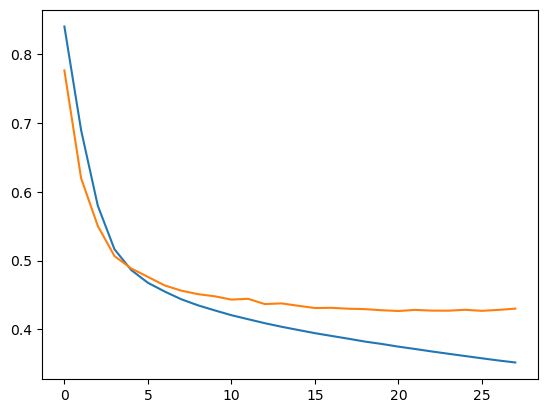

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Validation

In [36]:
batches = [batch for batch in val_dataset]

preds_list = []
ground_truth_list = []

for batch in batches[:1]:
    source = batch[0]
    target = batch[1].numpy()
    bs = tf.shape(source)[0]
    preds = model.generate(source, start_token_idx)
    preds = preds.numpy()

    for i in range(bs):
        target_text = "".join([idx_to_char[_] for _ in target[i, :]])
        ground_truth_list.append(target_text.replace('P', ''))
        prediction = ""
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == end_token_idx:
                break
        preds_list.append(prediction)

for i in range(10):
    print(ground_truth_list[i])
    print(preds_list[i])
    print('\n~~~\n')

S3 creekhouseE
S33 creekhorseE

~~~

Sscales/kuhaylahE
Ssemales nhauhhailaE

~~~

S1383 william lanierE
S1386 william lanierE

~~~

S988 franklin laneE
S988 franlin laneE

~~~

S6920 northeast 661st roadE
S69920 northeast 66th stroadE

~~~

Swww.freem.ne.jpE
Swww.freem.mee.itE

~~~

Shttps://jsi.is/hukuokaE
Shttps://jsi.iss/tkurokaE

~~~

S239613 stolze streetE
S23961 stold lzearetE

~~~

S271097 bayshore boulevardE
S271097 bay pore boulevardE

~~~

Sfederico pearsonE
Sfederico pearonE

~~~



In [37]:
ground_truth_processed = [ground_truth_list[i][1:-1] for i in range(len(ground_truth_list))]
preds_list_processed = [preds_list[i][1:-1] for i in range(len(preds_list))]
lev_dist = [lev.distance(ground_truth_processed[i], preds_list_processed[i])
            for i in range(len(preds_list_processed))]
N = [len(phrase) for phrase in ground_truth_processed]

print('Validation score: '+str((np.sum(N) - np.sum(lev_dist))/np.sum(N)))

Validation score: 0.7667238421955404


# Levenstein Distance Train

In [39]:
# Compute Levenstein Distances
def get_ld_train():
    N = 100 if IS_INTERACTIVE else 1000
    LD_TRAIN = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train, total=N), y_train)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_TRAIN.append({
            'phrase_true': phrase_true,
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break

    # Convert to DataFrame
    LD_TRAIN_DF = pd.DataFrame(LD_TRAIN)

    return LD_TRAIN_DF

# TFLiteModel

In [40]:
 class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(SEL_COLS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(SEL_COLS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}

tflitemodel_base = TFLiteModel(model)

In [41]:
model.save_weights("model.h5")

In [42]:
# 重みの読み込み
model.load_weights('model.h5')

# モデルの形状を表示
model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 landmark_embedding (Landmar  (None, 128, 256)         2387456   
 kEmbedding)                                                     
                                                                 
 token_embedding (TokenEmbed  multiple                 410624    
 ding)                                                           
                                                                 
 sequential_4 (Sequential)   (None, 128, 256)          6162608   
                                                                 
 transformer_decoder (Transf  multiple                 2310800   
 ormerDecoder)                                                   
                                                                 
 dense_14 (Dense)            multiple                  15934     
                                                       

In [43]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

infargs = {"selected_columns" : SEL_COLS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

Tensor("cond_2/Pad:0", shape=(None, 26, 3), dtype=float32)


In [44]:
!zip submission.zip  './model.tflite' './inference_args.json'

updating: model.tflite (deflated 14%)
updating: inference_args.json (deflated 85%)


In [45]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][0])
prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
print(prediction_str)

8 pinner lane
